Andreev spectrum of nanostructure-based junction
syst1: TI system without TRS

# import Kwant

In [2]:
import kwant
print(kwant.version.version)

import matplotlib

import matplotlib.pyplot as plt
#plt.style.use('genstyle')

import pandas as pd

import scipy.sparse.linalg as sla

import numpy as np
import kwant
import kwant.continuum
import peierls as peierls

import adaptive
import holoviews as hv
from holoviews import opts
adaptive.notebook_extension()
from concurrent.futures import ProcessPoolExecutor
from operator import itemgetter

import  sympy
from sympy.physics.matrices import msigma, Matrix
from sympy import eye
from sympy.physics.quantum import TensorProduct

from sympy.utilities.exceptions import SymPyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)


import scipy.signal
from scipy.stats import multivariate_normal

import time
import os
import path_generator as path_generator

/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


1.4.2


In [3]:
pd.options.display.float_format = "{:,.2f}".format

# System creation

In [4]:
import numpy as np

# shape of system
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

# shape of leads
def get_shape_lead_0(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def get_shape_lead_1(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([L, 0, 0])

L_x = 100
W_y = 100
H_z = 100

## 3DTI hamiltonian

In [5]:
import kwant.continuum


norbs = 8 # 8 orbitals (2 for particle-hole x 2 for spin up-down x 2 for orbitals A/B)
ham_TI = ("- mu_bulk * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) + "
          "S_mag * S_imp(site) * kron(sigma_z, sigma_0, sigma_0)")

ham_TI_lead1 = ("- mu_lead1 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) ")

ham_TI_lead2 = ("- mu_lead2 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) ")


epsilon = "(C_0 - C_perp * (k_x**2 + k_y**2) - C_z * k_z**2)"
M = "(M_0 - M_perp * (k_x**2 + k_y**2) - M_z * k_z**2)"

ham_TI = ham_TI.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)


ham_TI_lead1 = ham_TI_lead1.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr_lead1, coords = kwant.continuum.discretize_symbolic(ham_TI_lead1)

ham_TI_lead2 = ham_TI_lead2.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr_lead2, coords = kwant.continuum.discretize_symbolic(ham_TI_lead2)


signs = [-1, -1, -1, -1, 1, 1, 1, 1]
vector_potential='[-B_z * y, -B_x * z, -B_y * x]'
ham_discr = peierls.apply(ham_discr, coords, A=vector_potential, signs=signs)
ham_discr_lead1 = peierls.apply(ham_discr_lead1, coords, A=vector_potential, signs=signs)
ham_discr_lead2 = peierls.apply(ham_discr_lead2, coords, A=vector_potential, signs=signs)

In [6]:
a = 10
ti_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
ti_lead_0 = kwant.continuum.build_discretized(ham_discr_lead1, coords, grid=a)
ti_lead_1 = kwant.continuum.build_discretized(ham_discr_lead2, coords, grid=a)

In [7]:
syst1 = kwant.Builder()
_ = syst1.fill(ti_syst, *get_shape(L_x, W_y, H_z))

lat = kwant.lattice.cubic(a, norbs=norbs)

In [8]:
sigma_0 = np.identity(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
conservation_law = -np.kron(sigma_z, np.kron(sigma_0, sigma_0))
particle_hole = np.kron(sigma_x, np.kron(sigma_0, sigma_0))
sigma_TR = np.array([[0, -1], [1, 0]])
# i*sigma_y
time_reversal = np.kron(sigma_z, np.kron(sigma_TR, sigma_0))

nleads = 2

lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole
                      )
lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole
                      )

lead_0.fill(ti_lead_0, *get_shape_lead_0(L_x, W_y, H_z))
lead_1.fill(ti_lead_1, *get_shape_lead_1(L_x, W_y, H_z))

syst1.attach_lead(lead_0)
syst1.attach_lead(lead_1)

[]

In [9]:
systf1 = syst1.finalized()

## Define Disorder

### Uncorrelated Disorder

In [10]:
# Define a random number (following gaussian distribution) table for disorder
disorder_3D = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_x = np.array([[[kwant.digest.gauss(str(ind_x))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_y = np.array([[[kwant.digest.gauss(str(ind_y))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_z = np.array([[[kwant.digest.gauss(str(ind_z))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

def get_S_imp_3D():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_3D[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_x():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_x[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_y():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_y[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_z():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_z[ind_y, ind_x, ind_z]
    return S_imp

### Correlated Disorder

In [11]:
correlation_length = 10# in units of a (lattice constant)
#Smag_imp = 0.05

x, y, z = np.mgrid[-3*correlation_length:3*correlation_length+1:1, -3*correlation_length:3*correlation_length+1:1, -3*correlation_length:3*correlation_length+1:1]
pos = np.stack((x, y, z), axis=3)
rv = multivariate_normal([0, 0, 0], [[correlation_length**2, 0, 0], [0, correlation_length**2, 0], [0, 0, correlation_length**2]])
filter_kernel = rv.pdf(pos)

disorder = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_fil = scipy.signal.fftconvolve(disorder, filter_kernel, mode='same')
disorder_fil = disorder_fil/np.std(disorder_fil.flatten())

def get_S_imp_correlated():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        #return disorder[ind_y, ind_x, ind_z]
        return disorder_fil[ind_y, ind_x, ind_z]
    return S_imp

## Params dict

In [13]:
#params_toy = dict(C_0=0.0,
#                  C_2=3.0,
#                  mu=0.012
#                 )


params_toy = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0205,
                  mu_lead1=0.0205,
                  mu_lead2=0.021,
                  S_imp = get_S_imp_x(),
                  S_mag = 0.000
                 )

params_toy_sim = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0,
                 )

#params_TI = dict(A_perp=3.0,
#                 A_z=3.0,
#                 M_0=0.3,
#                 M_perp=15.0,
#                 M_z=15.0,
#                 C_0=0.0,
#                 C_perp=0.0,
#                 C_z=0.0,
#                 m_z=0.0,
#                 mu=0.1
#                )

params_TI = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu_bulk=0.04,
                 mu_lead1=0.04,
                 mu_lead2=0.04,
                 S_imp = get_S_imp_correlated(),
                 S_mag = 0.015,
                 B_x = 0.25/(W_y*H_z),  ## quarter flux
                 B_y = 0,
                 B_z = 0,
                 phi_0=1.0,
                 exp=np.exp,
                 a = 10
                 )

params_TI_sim = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu=0
                )

# Andreev spectrum

## Find Bound States (helper functions)

### Single Channel

In [14]:
def energy_operator_mask(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    #print(smat.submatrix(0, 0))
    #print(smat.submatrix(1, 1))
    size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
    size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
    mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    

    mask_e[:size_L, :size_L] = True
    mask_h[size_L:2*size_L, size_L:2*size_L] = True
    mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
    mask_e[2*size_L:2*size_L+size_R,:size_L] = True
    mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
    mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True
    

    smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
    smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))
    #smat_h = reverse(smat_h)

    
    smat_h_copy = np.array(list(smat_h))
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

## Calibrate the phase shift
    #shift_e = np.angle(smat_e[0][1]) - np.angle(smat_e[1][0])
    #shift_matrix_e = np.block([[1, 0], [0, np.exp(1j*shift_e/2)]])    
    #smat_e = shift_matrix_e@smat_e@shift_matrix_e.conj()
    #shift_h = np.angle(smat_h[0][1]) - np.angle(smat_h[1][0])
    #shift_matrix_h = np.block([[1, 0], [0, np.exp(1j*shift_h/2)]])   
    #smat_h = shift_matrix_h@smat_h@shift_matrix_h.conj()
        
    
## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) + 0.25 * (smat_prod + smat_prod.T.conj())]

def energy_operator_block(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    size_L = int(smat.num_propagating(0)/2)
    size_R = int(smat.num_propagating(1)/2)
        
    smat_e = np.block([[smat.submatrix((0,0),(0,0)), smat.submatrix((0,0),(1,0))],
         [smat.submatrix((1,0),(0,0)), smat.submatrix((1,0),(1,0))]])
    smat_h = np.block([[smat.submatrix((0,1),(0,1)), smat.submatrix((0,1),(1,1))],
         [smat.submatrix((1,1),(0,1)), smat.submatrix((1,1),(1,1))]])
    
    smat_h_copy = np.array(list(smat_h))
    


    
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

## Calibrate the phase shift
    #shift_e = np.angle(smat_e[0][1]) - np.angle(smat_e[1][0])
    #shift_matrix_e = np.block([[1, 0], [0, np.exp(1j*shift_e/2)]])    
    #smat_e = shift_matrix_e@smat_e@shift_matrix_e.conj()
    #shift_h = np.angle(smat_h[0][1]) - np.angle(smat_h[1][0])
    #shift_matrix_h = np.block([[1, 0], [0, np.exp(1j*shift_h/2)]])   
    #smat_h = shift_matrix_h@smat_h@shift_matrix_h.conj()
    
## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) + 0.25 * (smat_prod + smat_prod.T.conj())]


def e_squared_over_delta(syst, p, ph_sym=False, phases=np.zeros(nleads), method='mask'):
    if method == 'mask':
        operator = energy_operator_mask(syst, p, ph_sym, phases)
    elif method == 'block':
        operator = energy_operator_block(syst, p, ph_sym, phases)
    return np.linalg.eigvalsh(operator[2])

def energies_over_delta(syst, p, ph_sym=False, phases=np.zeros(nleads), method='mask'):
    """Same as energy_operator(), but returns the 
    square-root of the eigenvalues"""
    if method == 'mask':
        operator = energy_operator_mask(syst, p, ph_sym, phases)
    elif method == 'block':
        operator = energy_operator_block(syst, p, ph_sym, phases)
    return np.sqrt(np.linalg.eigvalsh(operator[2]))

def plot_ABS_spectrum(syst, p, phases, n=3, ph_sym=False, method='mask', r=False):
    params = p.copy()
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\phi/\pi$')
    ax.set_ylabel(r'$E/\Delta$')

    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta(syst, params, ph_sym=ph_sym, phases=phase, method=method))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    i = 0
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=str(i))
        ax.plot(phases, -1*sol, 'C'+str(i))
        i+=1
    ax.legend()
    if r:
        return sol_list2
    
def find_gap(syst, p, n=0, ph_sym=False, method='mask'):
    phases = [0, np.pi]
    return 2*energies_over_delta(syst, p, ph_sym=ph_sym, phases=phases, method=method)[n]

### Multichannel

In [15]:
def energy_operator_calibrated(syst, p, phases=np.zeros(nleads), calibration=None):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    #print(smat.submatrix(0, 0))
    #print(smat.submatrix(1, 1))
    size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
    size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
    mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    

    mask_e[:size_L, :size_L] = True
    mask_h[size_L:2*size_L, size_L:2*size_L] = True
    mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
    mask_e[2*size_L:2*size_L+size_R,:size_L] = True
    mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
    mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True
    

    smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
    smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))
    #smat_h = reverse(smat_h)

    
    smat_h_copy = np.array(list(smat_h))
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    if calibration is None:
        calibration_e = np.identity(size_L+size_R, dtype=complex)

    ## Assuming the left lead and the right lead have the same dimensions (same number of propagating modes)
    ## Calibrate the phase shift        
        for i in range(0, size_L):
            shift_e = np.angle(smat_e[i][i+size_L]) - np.angle(smat_e[i+size_L][i])
            calibration_e[i+size_L][i+size_L] = np.exp(1j*shift_e/2)
    else:
        print('same calibration!')
        calibration_e = calibration
    
    smat_e = calibration_e@smat_e@calibration_e.conj()
        

#    Use particle-hole symmetry    
    smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) + 0.25 * (smat_prod + smat_prod.T.conj()), calibration_e]



def energies_over_delta_calibrated(syst, p, phases=np.zeros(nleads), calibration=None):
    operator = energy_operator_calibrated(syst, p, phases, calibration=calibration)

    return np.sqrt(np.linalg.eigvalsh(operator[2]))

def plot_ABS_spectrum_calibrated(syst, p, phases, r=False, calibration=None):

    params = p.copy()
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\phi/\pi$')
    ax.set_ylabel(r'$E/\Delta$')

    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(syst, params, phases=phase, calibration=calibration))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    i = 0
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=str(i))
        ax.plot(phases, -1*sol, 'C'+str(i))
        i+=1
    ax.legend()

    if r:
        return sol_list2
    
def find_gap(syst, p, n=0, ph_sym=True):
    phases = [0, np.pi]
    return 2*energies_over_delta_calibrated(syst, p, phases=phases)[n]

## Test

### Find single channel potential

In [33]:
mus = np.linspace(0, 0.4, 401)
channels = np.zeros((mus.shape[0]))

time_start = time.time()

params_TI['mu_bulk'] = 0.01

for index_S, mu_S in enumerate(mus):
    params_TI['mu_lead1'] = mu_S
    params_TI['mu_lead2'] = mu_S
    smat = kwant.smatrix(systf1, params=params_TI)

    channels[index_S] = (smat.num_propagating(0))

    time_current = time.time()
    percentage = (index_S + 1)/mus.shape[0]
    time_left = (time_current - time_start)/percentage - (time_current - time_start) 

    print("Time elapsed : ", time_current - time_start, "Time remaining : ", time_left, "Percentage : ", percentage*100)


np.savetxt(fname = f".\\Data\\mu_TI_to_S_{mus.shape[0]}_{mus[-1]}.txt", X = channels)

Time elapsed :  4.416079998016357 Time remaining :  1766.431999206543 Percentage :  0.24937655860349126


KeyboardInterrupt: 

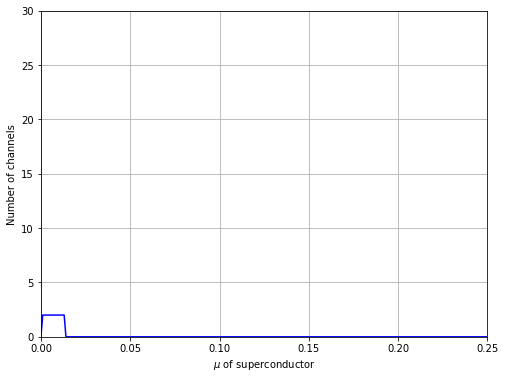

In [ ]:
import path_generator as path_generator
dimension = 401 # 50, 50, 401
max_value = 0.4 # 1, 0.04, 0.4

#channels = np.loadtxt(fname = f".\\Data\\mu_TI_to_S_{dimension}_{dimension}_{max_value}.txt")
#path = path_generator.generate_path("Data", f"mu_TI_to_S_{dimension}_{max_value}"  ,"txt")
#channels = np.loadtxt(fname = path)

mu_ti = np.linspace(0, max_value, dimension)
"""
mu_super = mu_ti

plt.pcolormesh(mu_ti,mu_super , channels, shading='nearest')
plt.colorbar()

plt.ylabel('$\mu$ of normal region')
plt.xlabel('$\mu$ of superconductor')
#plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{dimension}_{max_value}.pdf")
plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{max_value}.pdf")

plt.show()
# """
plt.figure(figsize = (8,6))
plt.plot(mu_ti, channels,"b")
plt.xlabel('$\mu$ of superconductor')
plt.ylabel('Number of channels')
plt.grid()
plt.xlim(0, 0.25)
plt.ylim(0, 30)

path = path_generator.generate_path("Images",f"mu_TI_to_S_{dimension}_{max_value}","pdf")
#print(path)
#plt.savefig("Images/test.pdf")
plt.savefig(fname = path)


plt.show()

### Check Scattering Matrix

#### Uncalibrated with random phase shift

In [ ]:
mu = 0.042
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
result = energy_operator_mask(systf1, params_TI, ph_sym=False)
smat_e = pd.DataFrame(result[0])
smat_h = pd.DataFrame(result[1])
print(smat_e)
print(smat_h)
#sol = energies_over_delta(systf1, params_TI, phases=[0, np.pi], method='mask')
#print(sol)

            0           1           2           3           4           5
0  0.00+0.00j  0.00+0.00j  0.00-0.00j  0.97-0.23j -0.00+0.00j  0.00+0.00j
1  0.00+0.00j -0.00+0.00j -0.00-0.00j -0.00-0.00j -0.47+0.88j -0.00+0.00j
2  0.00+0.00j  0.00+0.00j -0.00+0.00j  0.00+0.00j -0.00-0.00j -0.05-1.00j
3 -0.70+0.71j  0.00+0.00j  0.00-0.00j -0.00-0.00j  0.00+0.00j  0.00-0.00j
4  0.00+0.00j  0.93-0.36j  0.00-0.00j  0.00+0.00j -0.00-0.00j -0.00-0.00j
5  0.00+0.00j  0.00+0.00j  0.40-0.92j -0.00+0.00j  0.00-0.00j  0.00-0.00j
            0           1           2           3           4           5
0  0.00-0.00j  0.00-0.00j  0.00+0.00j  0.97+0.23j -0.00-0.00j  0.00-0.00j
1  0.00-0.00j -0.00-0.00j -0.00+0.00j -0.00+0.00j -0.47-0.88j -0.00-0.00j
2  0.00-0.00j  0.00-0.00j -0.00-0.00j  0.00-0.00j -0.00+0.00j -0.05+1.00j
3 -0.70-0.71j  0.00-0.00j  0.00+0.00j -0.00+0.00j  0.00-0.00j  0.00+0.00j
4  0.00-0.00j  0.93+0.36j  0.00+0.00j -0.00-0.00j -0.00+0.00j  0.00+0.00j
5  0.00-0.00j  0.00-0.00j  0.40+0.92j 

#### Multiple channels with calibrated phase

In [ ]:
mu = 0.042
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
result = energy_operator_calibrated(systf1, params_TI, calibration=None)
smat_e = pd.DataFrame(result[0])
smat_h = pd.DataFrame(result[1])
#sol = energies_over_delta_calibrated(systf1, params_TI, phases=[0, np.pi])


            0           1           2           3           4           5
0  0.00+0.00j  0.07-0.03j  0.02+0.07j -0.10-0.98j -0.00+0.09j -0.09+0.00j
1 -0.02-0.07j -0.52+0.84j  0.00+0.00j -0.05-0.07j -0.03-0.13j -0.01-0.01j
2  0.06-0.03j  0.00+0.00j -0.53+0.83j -0.06+0.06j  0.01+0.00j -0.05-0.12j
3 -0.10-0.98j  0.06-0.06j -0.05-0.07j  0.00-0.00j  0.03-0.07j -0.07-0.03j
4  0.09+0.01j -0.03-0.13j  0.00+0.01j -0.07-0.04j -0.83-0.54j  0.00-0.00j
5  0.02+0.09j -0.01-0.00j -0.05-0.12j -0.01+0.08j  0.00-0.00j -0.96-0.20j
[[ 1.75922058e-04+9.56460604e-04j  6.61182213e-02-3.08382553e-02j
   1.92017257e-02+6.95354918e-02j -9.87879810e-02-9.81484235e-01j
  -2.00293881e-04+9.06341014e-02j -9.04312855e-02+3.12733412e-03j]
 [-2.29306139e-02-6.89249445e-02j -5.15416131e-01+8.39709712e-01j
   9.25672875e-07+1.71708301e-05j -5.02671957e-02-6.72991832e-02j
  -2.62291602e-02-1.26995117e-01j -6.08298172e-03-6.97483153e-03j]
 [ 6.46182611e-02-3.27602152e-02j  1.22613322e-05+1.61836362e-05j
  -5.33257394e-01+

### Check Andreev Spectrum

#### Single Channel with calibrated phase shift

KeyboardInterrupt: 

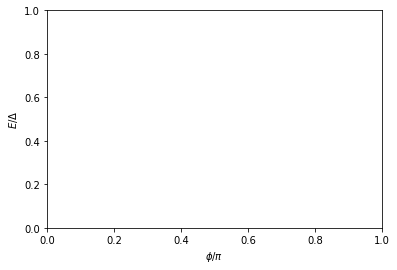

In [35]:
mu = 0.02
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
phases = np.linspace(0,2,51)
plot_ABS_spectrum(systf1, params_TI, phases)

#### Multi-channel with calibrated phase shift

KeyboardInterrupt: 

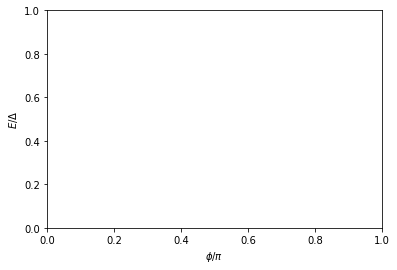

In [36]:
mu = 0.042   # get rid of the potential mismatch and add in disorder. for same potential all ABS become MBS
params_TI['mu_bulk'] = mu   ### cor disorder produces values with function, uncor disorder tot random
params_TI['mu_lead1'] = mu           # diff in potential creates backscattering, which affects transmission
params_TI['mu_lead2'] = mu
params_TI["S_imp"] = get_S_imp_3D()

s_mag = np.linspace(0,0.01,21)
phases = np.linspace(0,2,21)

time_start = time.time()

for i in range(len(s_mag)):
    params_TI["S_mag"] = s_mag[i]
    results = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)
    
    path = path_generator.generate_path("Images",f"multi_channel_0.5_{s_mag[i]}","pdf")
    plt.savefig(fname = path)
    
    plt.show()
    
    time_current = time.time()
    percentage = (i + 1)/len(s_mag)
    time_left = (time_current - time_start)/percentage - (time_current - time_start) 

    print("Time elapsed : ", time_current - time_start, "Time remaining : ", time_left, "Percentage : ", percentage*100)



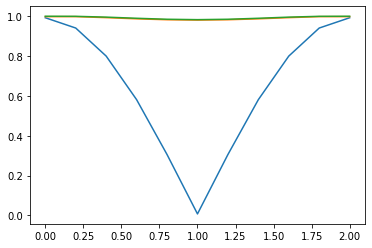

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(phases, results[0])
plt.plot(phases, results[1])
plt.plot(phases, results[2])
a = np.zeros(phases.size)
plt.plot(phases, a)
plt.show()

In [ ]:
mu = 0.05   # get rid of the potential mismatch and add in disorder. for same potential all ABS become MBS
params_TI['mu_bulk'] = mu   ### cor disorder produces values with function, uncor disorder tot random
params_TI['mu_lead1'] = mu           # diff in potential creates backscattering, which affects transmission
params_TI['mu_lead2'] = mu
params_TI["S_imp"] = get_S_imp_3D()

s_mag_s = 0.02
phases = np.linspace(0,2,21)


params_TI["S_mag"] = s_mag
resultssss = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)

path = path_generator.generate_path("Images",f"multi_channel_0.5_{s_mag[i]}","pdf")
plt.savefig(fname = path)


plt.show()


plt.figure(figsize=(15,15))
plt.plot(phases, results[0])
plt.plot(phases, results[1])
plt.plot(phases, results[2])
a = np.zeros(phases.size)
plt.plot(phases, a)
plt.show()

NameError: name 's_mag' is not defined

## Tasks

In [41]:
# Testing 

import path_generator as path_generator
path_generator.function(3)


AttributeError: module 'path_generator' has no attribute 'function'

In [38]:
# Generating scattering matrices
import path_generator as path_generator
path = path_generator.generate_path(("Data","quarterflux_Scattering_Matrices_0.02"),f"mu_bulk_{params_TI['mu_bulk']}_S_mag_{params_TI['S_mag']}","txt")

mus = np.linspace(-0.05, 0.2, 51)
Smags = np.linspace(0, 0.05, 51)
params_TI['mu_lead1'] = 0.02  ## single channel
params_TI['mu_lead2'] = 0.02

time_start = time.time()

for i, mu in enumerate(mus):
    params_TI['mu_bulk'] = 0.02 + mu
    
    for j, s in enumerate(Smags):
        params_TI['S_mag'] = s
        result = energy_operator_calibrated(systf1, params_TI, calibration=None)
        
        smat_e = np.array(pd.DataFrame(result[0]))
        
        path = path_generator.generate_path(("Data","quarterflux_Scattering_Matrices_0.02"), f"mu_bulk_{params_TI['mu_bulk']}_S_mag_{params_TI['S_mag']}","txt")
        np.savetxt(fname =path, X = smat_e)
        
        time_current = time.time()
        percentage = (i*len(Smags) + j + 1)/(len(Smags)*len(mus))
        time_left = (time_current - time_start)/percentage - (time_current - time_start) 
        print("Time elapsed : ", "{:.1f}".format(time_current - time_start), "Time remaining : ", "{:.1f}".format(time_left), "Percentage : ", "{:.3f}".format(percentage*100))


Exception: Wrong data type for rel_path

30
30
0.08700000000000001
0.0
here
0.0945
0.0
here
0.10200000000000001
0.0
here
0.10366666666666668
0.005555555555555556
here
0.11116666666666666
0.005555555555555556
here
0.11866666666666667
0.005555555555555556
here
0.12033333333333335
0.011111111111111112
here
0.12783333333333335
0.011111111111111112
here
0.13533333333333333
0.011111111111111112
here
0.137
0.016666666666666666
here
0.14450000000000002
0.016666666666666666
here
0.15200000000000002
0.016666666666666666
here
0.15366666666666667
0.022222222222222223
here
0.16116666666666668
0.022222222222222223
here
0.1686666666666667
0.022222222222222223
here
0.17033333333333336
0.02777777777777778
here
0.17783333333333337
0.02777777777777778
here
0.18533333333333335
0.02777777777777778
here
0.18700000000000003
0.03333333333333333
here
0.19450000000000003
0.03333333333333333
here
0.202
0.03333333333333333


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.2036666666666667
0.03888888888888889


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.2111666666666667
0.03888888888888889


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.21866666666666668
0.03888888888888889


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.22033333333333335
0.044444444444444446


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.22783333333333336
0.044444444444444446


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.23533333333333334
0.044444444444444446


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.23700000000000004
0.05


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.24450000000000002
0.05


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.252
0.05


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
30
30
0.137
0.0


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.14450000000000002
0.0


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.152
0.0


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.17400000000000002
0.005555555555555556


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.18150000000000002
0.005555555555555556


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.18900000000000003
0.005555555555555556


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.21100000000000002
0.011111111111111112


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.21850000000000003
0.011111111111111112


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.226
0.011111111111111112


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.24800000000000003
0.016666666666666666


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.2555
0.016666666666666666


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.263
0.016666666666666666


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.28500000000000003
0.022222222222222223


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.29250000000000004
0.022222222222222223


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.3
0.022222222222222223


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


here
0.322
0.02777777777777778


/Users/leonardobossi1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

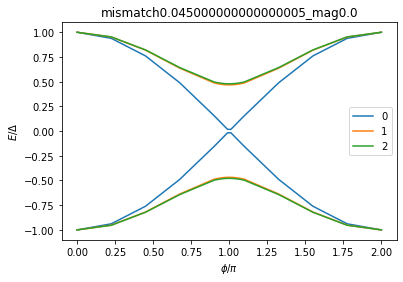

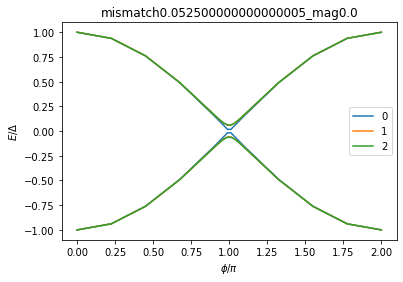

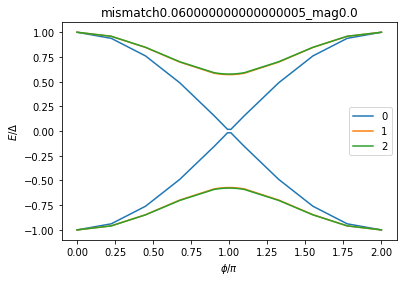

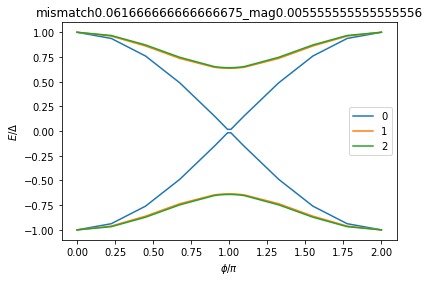

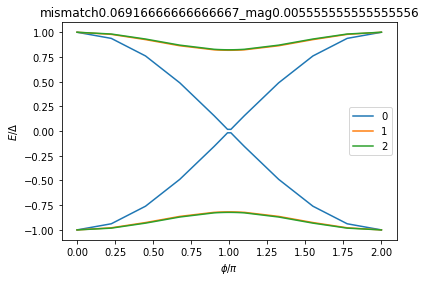

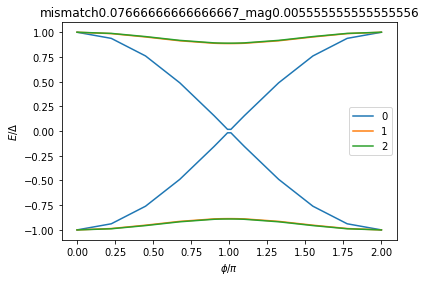

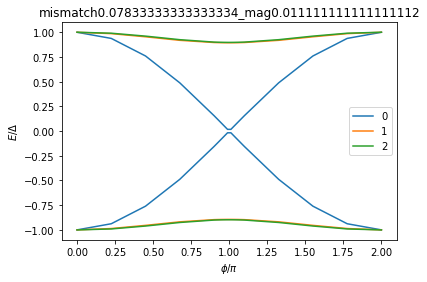

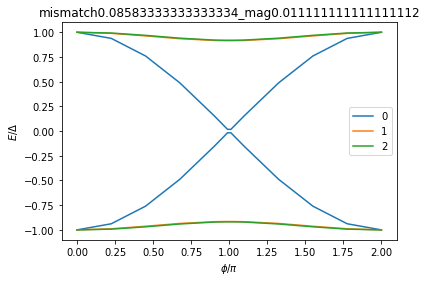

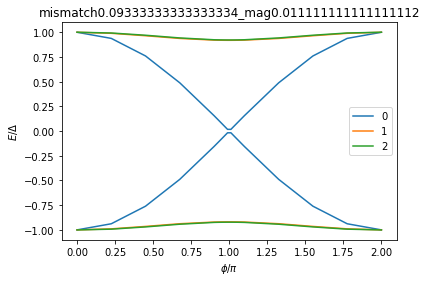

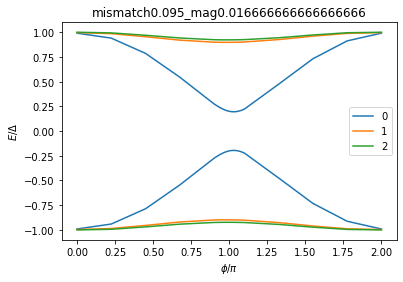

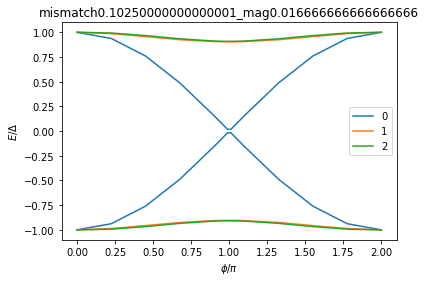

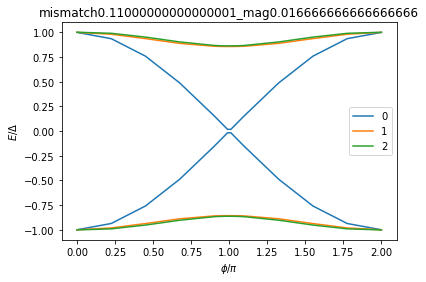

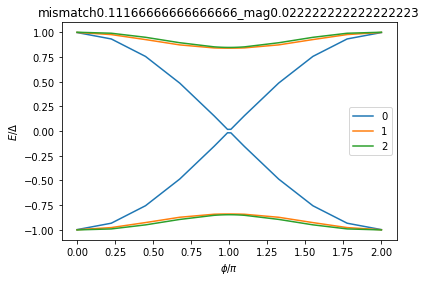

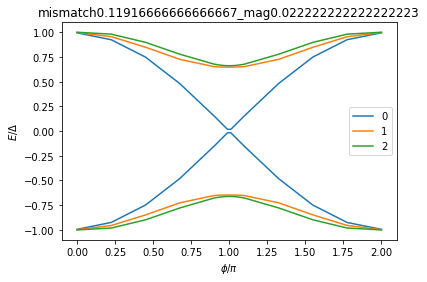

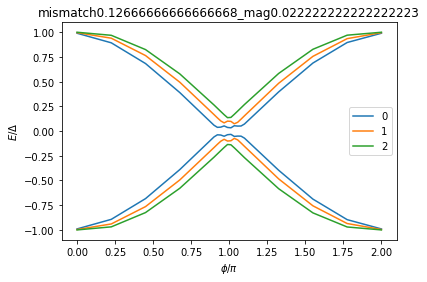

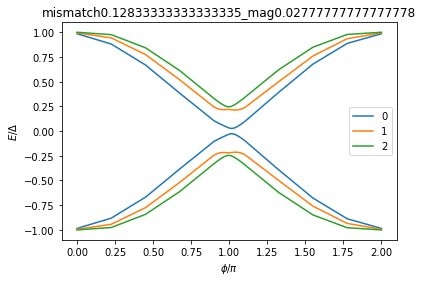

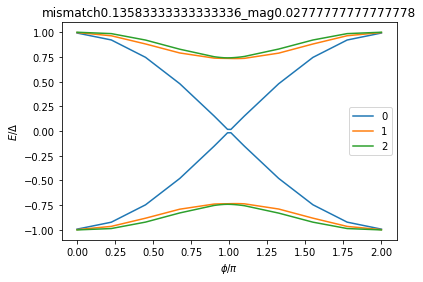

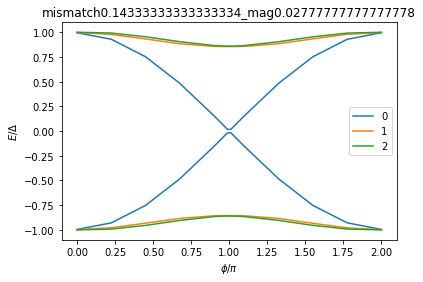

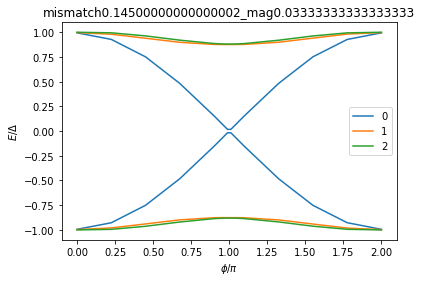

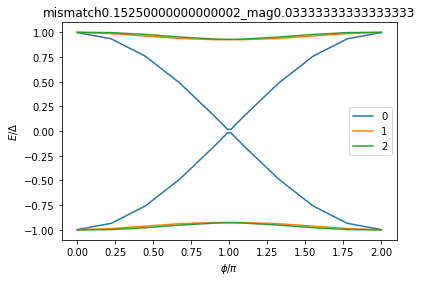

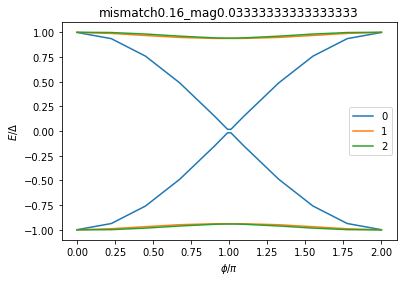

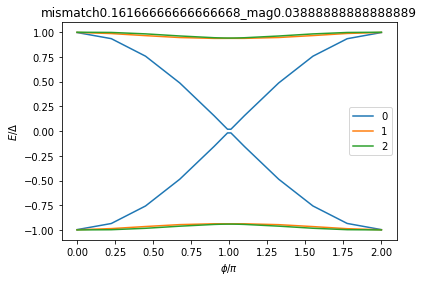

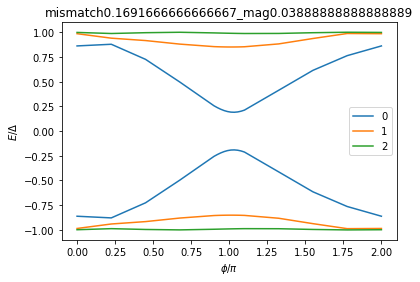

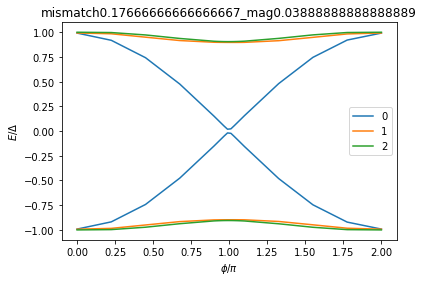

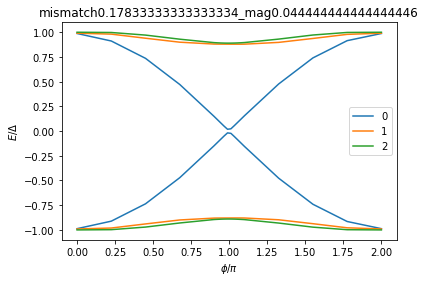

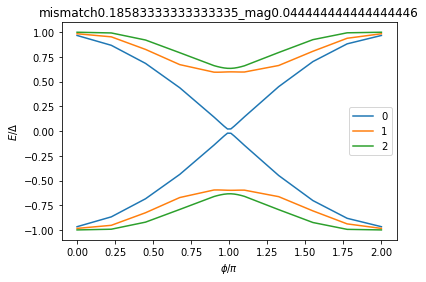

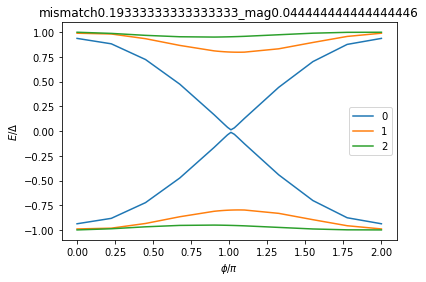

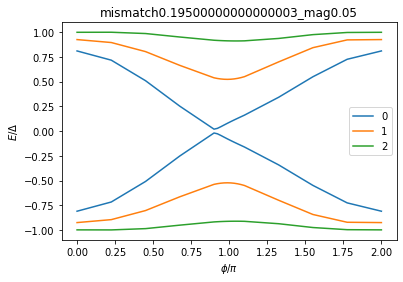

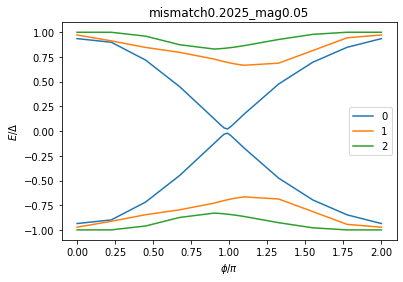

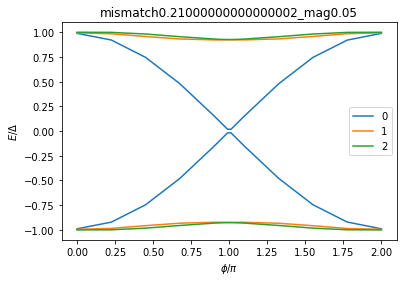

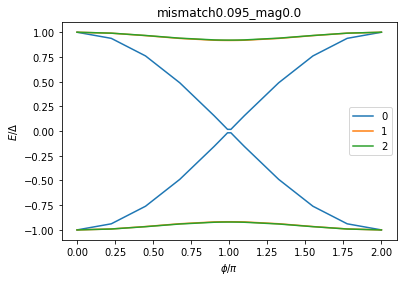

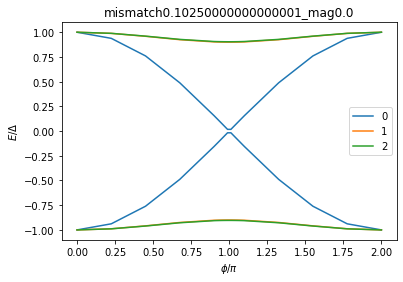

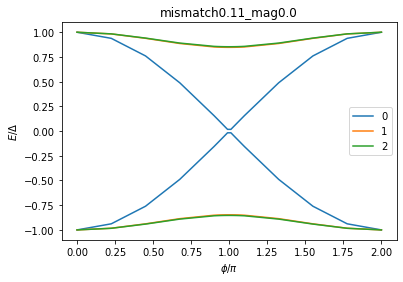

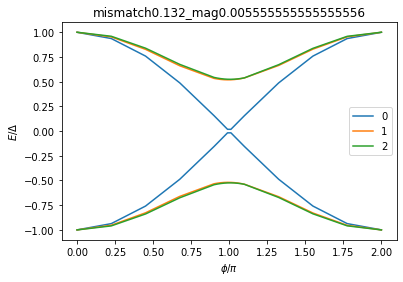

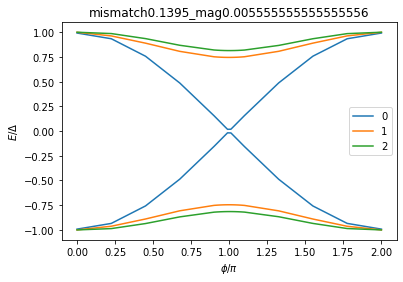

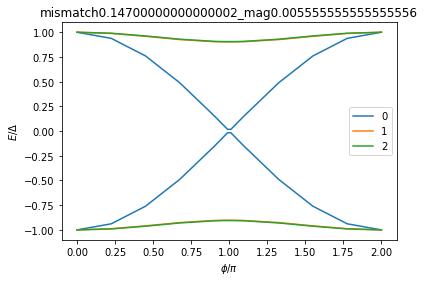

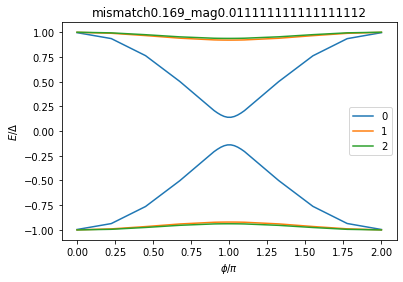

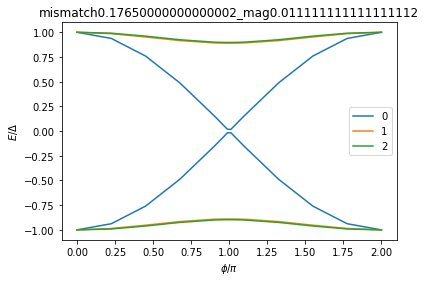

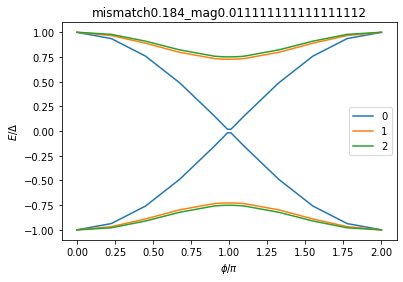

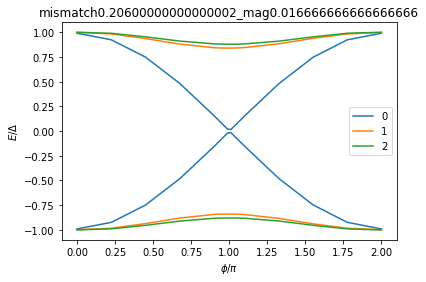

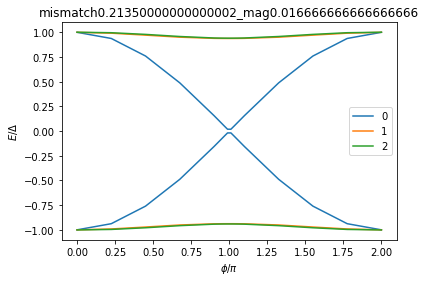

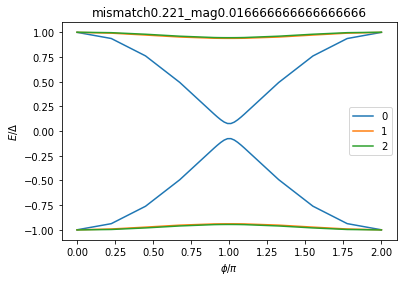

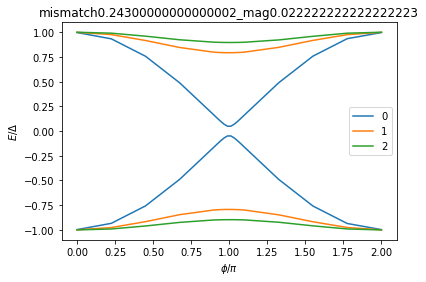

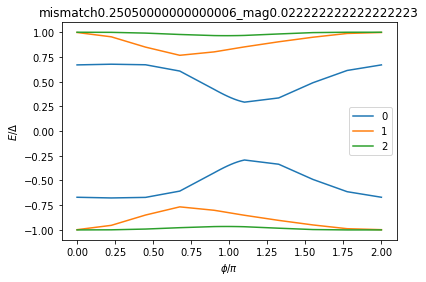

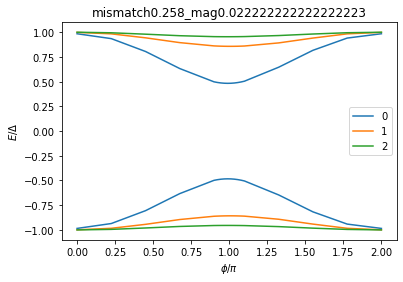

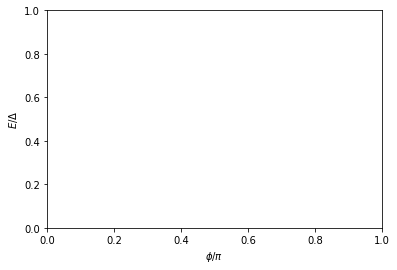

In [52]:
# Originally scanned region
#mus = np.linspace(-0.05, 0.2, 51)
#Smags = np.linspace(0, 0.05, 51)

# More precisely scanned region 
# Boxes to be scanned (all set to 20 values)
mus_pres1 = np.linspace(-0.05, 0, 3)
Smags_pres1 = np.linspace(0.04, 0.05, 3)

mus_pres2 = np.linspace(0.175, 0.2, 3)
Smags_pres2 = np.linspace(0, 0.01, 3)

## lines to be scanned
def y1(x,c):
    return c+ 0.05 + 3 * x 

def y2(x, c):
    return c+ 0.1 + 6.66 * x 

Smags_extra = np.linspace(0, 0.05, 10) # 80
const_vals = np.linspace(-0.005, 0.01, 3) # 10
mus_extras = []
mus_extras2 = []

Smags_values = [] 

for val in Smags_extra:
    for c in const_vals:
        mus_extras.append(y1(val,c))
        mus_extras2.append(y2(val, c))
        Smags_values.append(val)

params_TI['mu_lead1'] = 0.042
params_TI['mu_lead2'] = 0.042

mu_list = [mus_extras, mus_extras2, mus_pres1, mus_pres2]
mag_list = [Smags_values, Smags_values, Smags_pres1 ,Smags_pres2]

phasemiddle = np.linspace(0.90, 1.10, 10 )
phaseminus =  np.linspace(0, 0.9, 5)
phaseplus = np.linspace(1.1, 2, 5)

phases = np.concatenate((phaseminus,phasemiddle, phaseplus ), axis = None)


for i in range(2):
    mus = mu_list[i]
    Smags = mag_list[i]
    gaps = []
    print(len(mu_list[1]))
    print(len(mag_list[1]))

    for item in range(len(mus)):
        gap_mu = []
        print(0.042 + mus[item])
        print(Smags[item] )

        params_TI['mu_bulk'] = 0.042 + mus[item]
        params_TI['S_mag'] = Smags[item] 
        results = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)
        print('here')
        path = path_generator.generate_path("Images",f"multi_channel_0.042_mismatch{mus[item]}_mag{Smags[item]}","png")
        plt.title(f"mismatch{mus[item]}_mag{Smags[item]}")
        plt.savefig(fname = path)


for i in range(2):
    mus = mu_list[i]
    Smags = mag_list[i]
    gaps = []

    for mu in mus:
        print(mu)
        gap_mu = []
        params_TI['mu_bulk'] = 0.042 + mu

        for s in Smags:
            params_TI['S_mag'] = s 
            results = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)
            path = path_generator.generate_path("Images",f"multi_channel_0.042_mismatch{mu}_mag{s}","png")
            plt.title(f"mismatch{mu}_mag{s}")
            plt.savefig(fname = path)


'''
gaps = []
mus=np.concatenate((mus_pres1 , mus_pres2 , mus_extras, mus_extras2), axis = None)
Smags = np.concatenate((Smags_pres1, Smags_pres2, Smags_extra, Smags_extra), axis = None)

counter = 1
for mu in mus:
    counter+=1
    print('current progress')
    print(counter/len(mus))
    gap_mu = []
    params_TI['mu_bulk'] = 0.042+mu
    for s in Smags:
        params_TI['S_mag'] = s
        #gap = find_gap(systf1, params_TI)
        #print(gap)
        #gap_mu.append(gap)
        results = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)

    gaps.append(gap_mu)
'''





In [ ]:
switches = [0.004, 0.042, 0.08, 0.12, 0.158, 0.196]

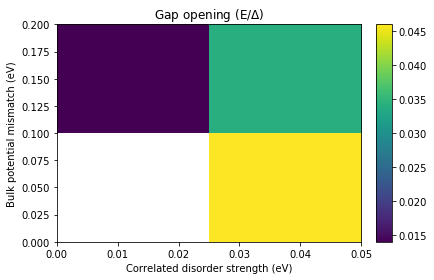

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
ax.set_xlabel('Correlated disorder strength (eV)')
ax.set_ylabel('Bulk potential mismatch (eV)')
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
ax.set_title(r'Gap opening (E/$\Delta$)')
im = ax.imshow(gaps,extent = (min(Smags), max(Smags), min(mus), max(mus)), 
                 origin='lower', aspect='auto')
fig.colorbar(im, cax=cax)

#for i in range(len(switches)):
#    ax.plot(Smags, switches[i] - Smags, label='# of modes={}'.format(2*i+1))
#ax.legend()

### Finding maximum absolute value for scattering matrix non symmetry/ time reversal symmetry

In [16]:
mus = np.linspace(-0.05, 0.2, 51)
Smags = np.linspace(0, 0.05, 51)


all_max_diff = []
params_TI['mu_lead1'] = 0.02
params_TI['mu_lead2'] = 0.02

computing_error = 1e-9

time_start = time.time()

for i, mu in enumerate(mus):
    abs_diff = []
    params_TI['mu_bulk'] = 0.02+mu
    
    for j, s in enumerate(Smags):
        params_TI['S_mag'] = s
        result = energy_operator_calibrated(systf1, params_TI, calibration=None) 
        
        smat_e = np.array(pd.DataFrame(result[0]))
        smat_e_T = np.transpose(smat_e)
        
        abs_smat_e = np.absolute(smat_e)
        abs_smat_e_T = np.transpose(abs_smat_e)  ## taking transpose
        Average = (abs_smat_e + abs_smat_e_T)/2
        
        zeros = np.zeros(Average.shape)
        norm_diff = np.absolute(smat_e - smat_e_T)/Average
        
        all_diff = np.where( Average < computing_error, zeros , norm_diff)

        max_diff = np.amax(all_diff)

        abs_diff.append(max_diff)
        
        time_current = time.time()
        percentage = (i*len(Smags) + j + 1)/(len(Smags)*len(mus))
        time_left = (time_current - time_start)/percentage - (time_current - time_start)
        print(int((time_current - time_start)))
        print("Time elapsed : ", int(time_current - time_start), "Time remaining : ", int(time_left), "Percentage : ", int(percentage*100))
        
        
    all_max_diff.append(abs_diff)
    
    
    
    
"""
df = pd.DataFrame(all_diff)
display(df)
"""

path = path_generator.generate_path("Data",f"quarterflux_singlechannel_TRSplot_{computing_error}","txt")
np.savetxt(fname =path, X = np.array(all_max_diff))

20
Time elapsed :  20 Time remaining :  52369 Percentage :  0
32
Time elapsed :  32 Time remaining :  42282 Percentage :  0
43
Time elapsed :  43 Time remaining :  37878 Percentage :  0
54
Time elapsed :  54 Time remaining :  35537 Percentage :  0
65
Time elapsed :  65 Time remaining :  34032 Percentage :  0
76
Time elapsed :  76 Time remaining :  33049 Percentage :  0
88
Time elapsed :  88 Time remaining :  32755 Percentage :  0
99
Time elapsed :  99 Time remaining :  32222 Percentage :  0
110
Time elapsed :  110 Time remaining :  31773 Percentage :  0
121
Time elapsed :  121 Time remaining :  31354 Percentage :  0
132
Time elapsed :  132 Time remaining :  31120 Percentage :  0
143
Time elapsed :  143 Time remaining :  30998 Percentage :  0
154
Time elapsed :  154 Time remaining :  30811 Percentage :  0
165
Time elapsed :  165 Time remaining :  30666 Percentage :  0
177
Time elapsed :  177 Time remaining :  30562 Percentage :  0
188
Time elapsed :  188 Time remaining :  30389 Percenta

KeyboardInterrupt: 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

mus = np.linspace(-0.05, 0.2, 51)
Smags = np.linspace(0, 0.05, 51)

computing_error = 1e-9 # 9 - 12
path = path_generator.generate_path("Data",f"Abs_diff_in_scattering_m_time_rev_symm_{computing_error}","txt")
all_max_diff = np.loadtxt(path)

fig, ax = plt.subplots()
ax.set_xlabel('Correlated disorder strength (eV)')
ax.set_ylabel('Bulk potential mismatch (eV)')
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
ax.set_title(f'Abs diff for threshold error {computing_error}')
im = ax.imshow(all_max_diff,extent = (min(Smags), max(Smags), min(mus), max(mus)), 
                 origin='lower', aspect='auto')
fig.colorbar(im, cax=cax)



FileNotFoundError: [Errno 2] No such file or directory: '/Data/Abs_diff_in_scattering_m_time_rev_symm_1e-09.txt'

### Varying bulk chemical potentials

In [ ]:
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

mus = np.linspace(0.01, 0.05, 5)

i = 0
for mu in mus:
    params_TI['mu_bulk'] = mu

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=r'$\mu_bulk$={0:.2f}'.format(mu))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

### Varying uncorrelated disorder strength

In [ ]:
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['S_imp'] = get_S_imp_3D()

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

S_mags = np.linspace(0.01, 0.05, 5)

i = 0
for s in S_mags:
    params_TI['S_mag'] = s

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label="S_mag={0:.2f}".format(s))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

### Varying correlated disorder strength

In [ ]:
print('Correlation length is {}'.format(correlation_length))
print('Lattice size is {}'.format(a))

params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['S_imp'] = get_S_imp_correlated()

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

S_mags = np.linspace(0.01, 0.05, 5)

i = 0
for s in S_mags:
    params_TI['S_mag'] = s

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label='S_mag={0:.2f}'.format(s))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

# Appendix

## Band Structure

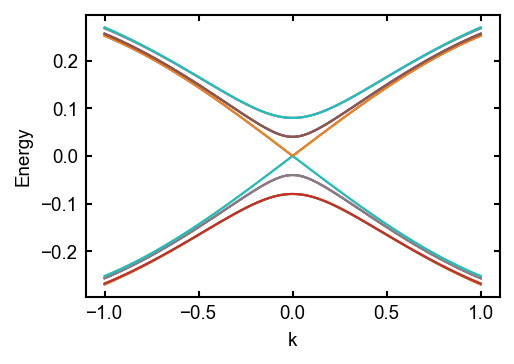

[[-0.27028874 -0.27028874 -0.26825626 ...  0.26825626  0.27028874
   0.27028874]
 [-0.26683437 -0.26683437 -0.26493896 ...  0.26493896  0.26683437
   0.26683437]
 [-0.26331033 -0.26331033 -0.26154377 ...  0.26154377  0.26331033
   0.26331033]
 ...
 [-0.26331033 -0.26331033 -0.26154377 ...  0.26154377  0.26331033
   0.26331033]
 [-0.26683437 -0.26683437 -0.26493896 ...  0.26493896  0.26683437
   0.26683437]
 [-0.27028874 -0.27028874 -0.26825626 ...  0.26825626  0.27028874
   0.27028874]]


In [ ]:
def plot_bands(syst, momenta, return_bands=False, plot_bands=True, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
    if plot_bands:
        fig, ax = plt.subplots()
        ax.set_xlabel('k')
        ax.set_ylabel('Energy')
        ax.plot(momenta, energies)
        #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
        #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
        plt.show()
    if return_bands:
        return energies
    

params_TI['mu_bulk'] = 0
params_TI['mu_lead1'] = 0
params_TI['mu_lead2'] = 0    
momenta = np.linspace(-1, 1, 101)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=10, params=params_TI)

print(r1)

## Visualise the disorder profile

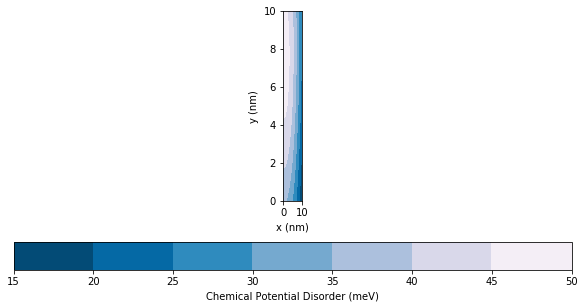

In [29]:
from matplotlib import cm

S_mag = 0.01

z=S_mag * disorder_fil.mean(axis =(2))*1000

x=np.linspace(0,L_x//a,L_x//a+1)
y=np.linspace(0,10,11) # Why is it ten?
X, Y = np.meshgrid(x, y)

fig, axs=plt.subplots(figsize=(10,5))

cs=axs.contourf(X,Y,z,cmap=cm.PuBu_r)
# plot = plt.contourf(X,Y,filter_kernel)
# plt.axis('scaled')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')


axs.set_aspect(10)

cbar=fig.colorbar(cs, orientation='horizontal', label='Chemical Potential Disorder (meV)')
plt.show()

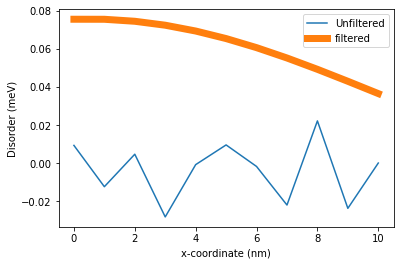

In [30]:
xval=np.linspace(0,L_x//a,L_x//a+1)
xvals=xval.astype(int)
dis=[]
dis2=[]
S_mag = 0.02
for x in xvals:
      dis.append(S_mag*disorder[0,x,0])

for x in xvals:
      dis2.append(S_mag*disorder_fil[0,x,0])
        
plt.plot(xvals,dis,label='Unfiltered')
plt.plot(xvals,dis2,linewidth=7,label='filtered')
plt.xlabel('x-coordinate (nm)')
plt.ylabel('Disorder (meV)')
plt.legend()
plt.show()

In [ ]:
disorder[0,1,0]